# Analyze SAXS Data on Nanoparticles in Water

The following code analyzes SAXS data on 50 +/- 3 nm SiO2 nanoparticles dispersed in water obtained during beamtime from 11/20/19-11/25/19 at the Argonne Photon Source (APS).

***NOT COMPLETE, NEEDS TO BE UPDATED FOR NEW DATA***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from scipy.signal import medfilt2d

import saxs
import saxsplot

from importlib import reload
reload(saxs)
reload(saxsplot)

# PARAMETERS
data_folder_path = '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\'
filename_structure = 'flow_hs104_*.tif'
r_lim = (15,500)
phi_lim = (-np.pi/2, 0)
averaged_coord = 'phi'
air_scan_list = []
water_scan_list = []
signal_bkgd_list = [(177, 176), (180, 179), (183, 182), (185, 184), (187, 186)]
conc_dict = {177:50*2**-6, 180:50*2**-5, 183:50*2**-4, 185:50*2**-3, 187:50*2**-2} # concentration of nanoparticles in ppm

## Load Data

We first load the images of SAXS patterns from the data and subtract the water background from them as a demonstration of the analysis software.

177 ['..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0000.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0001.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0002.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0003.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0004.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0005.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0006.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0007.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0008.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_176_0009.tif']
180 ['..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_179_0000.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\flow_hs104_179_0001.tif', '..\\..\\..\\EXPERIMENTS\\APS\\NP_1119\\SAXS\\flow\\fl

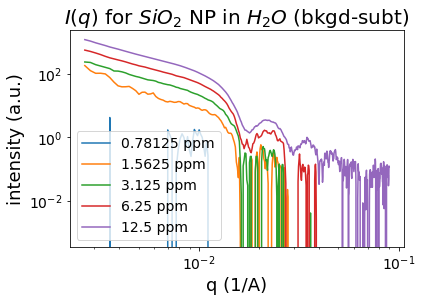

In [12]:
# Get file path
filepath_structure = os.path.join(data_folder_path,filename_structure)
file_list = glob.glob(filepath_structure)

# Average background intensities
bkgd_file_list = [saxs.get_scan_filenames([scan[1]], file_list) for scan in signal_bkgd_list]

# Organize data structures for intensity for each scan of data
file_list_by_scan = [saxs.get_scan_filenames([scan[0]], file_list) for scan in signal_bkgd_list]
scan_mean_list = []
q_list = []
intensity_list = []
label_list = []
scan_std_list = []
subt_std_list = []

# Average results from each scan and subtract background
for i in range(len(file_list_by_scan)):
    scan_file_list = file_list_by_scan[i]
    scan, _ = saxs.parse_scan_trial(scan_file_list[0])
    # get raw intensity and standard deviation (uncertainty)
    scan_mean, scan_std, q = saxs.compute_stats(scan_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)  
    # compute backgrond stats
    
    print(scan, bkgd_file_list[i])
    
    bkgd_mean, bkgd_std, q_bkgd = saxs.compute_stats(bkgd_file_list[i], averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    # background-subtracted intensity
    intensity_subt = scan_mean - bkgd_mean
    # estimate the error in the background-subtracted intensity by adding uncertainties in quadrature
    subt_std = np.sqrt(scan_std**2 + bkgd_std**2)
    # Store results
    scan_mean_list += [scan_mean] # raw intensity
    q_list += [q] # q values (wave numbers)
    intensity_list += [intensity_subt] # background-subtracted intensity
    label_list += ['{0:g} ppm'.format(conc_dict[scan])]
    scan_std_list += [scan_std] # standard deviation of raw intensity
    subt_std_list += [subt_std] # standard deviation of background-subtracted intensity
    
# Plot background-subtracted data
ax = saxsplot.plot(q_list, intensity_list, label_list=label_list, title=r'$I(q)$ for $SiO_2$ NP in $H_2O$ (bkgd-subt)')

We see that the characteristic peak of suspension of spheres is still distinguishable at a concentration of 6.25 ppm, and the plateau exceeds the noise at a concentration of 3.125 ppm.

### Curate Data for High School Students

To make analysis of these data easier, I will collect everything into a tidy dataframe using the Pandas library.

In [3]:
import pandas as pd

# initialize arrays with values for the background
q_arr = q_bkgd
I_mean_arr = bkgd_mean
s_I_arr = bkgd_std
I_subt_arr = np.zeros([len(q_bkgd)])
s_I_subt_arr = bkgd_std
particle_conc_arr = np.zeros([len(q_bkgd)])

for i in range(len(signal_bkgd_list)):
    q_arr = np.concatenate((q_arr, q_list[i]))
    I_mean_arr = np.concatenate((I_mean_arr, scan_mean_list[i]))
    s_I_arr = np.concatenate((s_I_arr, scan_std_list[i]))
    I_subt_arr = np.concatenate((I_subt_arr, intensity_list[i]))
    s_I_subt_arr = np.concatenate((s_I_subt_arr, subt_std_list[i]))
    particle_conc_arr = np.concatenate((particle_conc_arr, conc_dict[signal_bkgd_list[i][0]]*np.ones([len(q_list[i])])))

# create dataframe to save data in csv
df = pd.DataFrame()
df['particle concentration [ppm]'] = particle_conc_arr
df['q [1/A]'] = q_arr
df['mean intensity [a.u.]'] = I_mean_arr
df['standard deviation of intensity [a.u.]'] = s_I_arr
df['background-subtracted intensity [a.u.]'] = I_subt_arr
df['standard deviation of background-subtracted intensity [a.u.]'] = s_I_subt_arr
df.to_csv(data_folder_path + 'nanoparticle_scattering_data.csv', index=False)
df.head()

,particle concentration [ppm],q [1/A],mean intensity [a.u.],standard deviation of intensity [a.u.],background-subtracted intensity [a.u.],standard deviation of background-subtracted intensity [a.u.]
0,0.0,0.002693,3275.476000,22.829885,0.0,22.829885
1,0.0,0.002873,2738.668000,18.096153,0.0,18.096153
2,0.0,0.003052,2289.853333,22.290692,0.0,22.290692
3,0.0,0.003232,1932.358065,19.587629,0.0,19.587629
4,0.0,0.003411,1632.977419,10.755151,0.0,10.755151


## Characterize Background Signal

We wish to measure the background strength, variation in the background signal among trials within the same scan, and the drift in the background signal over time.

We begin with the mean and standard deviation of the air background (which includes the quartz capillary of the flow cell) and the water background.

In [4]:
# Average and standard deviation of background signal of air
for scan in air_scan_list:
    air_file_list = saxs.get_scan_filenames(scan, file_list)
    air_mean, air_std, q = saxs.compute_stats(air_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    saxsplot.plot([q], [air_mean], title='Mean I(q) of Air, Scan {scan}'.format(scan=scan))
    saxsplot.plot([q], [air_std], title='Standard Deviation of I(q) of Air, Scan {scan}'.format(scan=scan),
                 y_label=r'$\sigma_I$ (a.u.)')

# Average and standard deviation of background signals of water
for scan in water_scan_list:
    water_file_list = saxs.get_scan_filenames(scan, file_list)
    water_mean, water_std, q = saxs.compute_stats(water_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    saxsplot.plot([q], [water_mean], title='Mean I(q) of Water, Scan {scan}'.format(scan=scan))
    saxsplot.plot([q], [water_std], title='Standard Deviation of I(q) of Water, Scan {scan}'.format(scan=scan),
                 y_label=r'$\sigma_I$ (a.u.)')

Next we estimate the variation in the background water signal over time (drift). These scans were taken roughly 1 hour apart.

In [5]:
# Measure drift in background signal of water by subtracting mean from separate scans
mean_list = []
for scan in water_scan_list:
    water_file_list = saxs.get_scan_filenames(scan, file_list)
    water_mean, _, q = saxs.compute_stats(water_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    mean_list += [water_mean]
if len(mean_list) == 2:
    diff = mean_list[1] - mean_list[0]
    saxsplot.plot([q], [diff], title='Drift in I(q) of Water after 1 hour', y_label=r'$\Delta I$ (a.u.)', yscale='linear')
    saxsplot.plot([q], [np.abs(diff)], title='Magnitude of Drift in I(q) of Water after 1 hour', y_label=r'$\|\Delta I\|$ (a.u.)')

## Characterize Signal to Noise

In this section we compare the strength of the background to the signal strength and the noise in the signal.

SNR at plateau is 4.


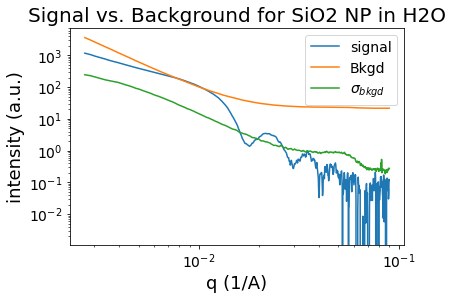

In [6]:
# Organize data structures for signal scan, background, and fluctuations
signal_scan = 186 #6.25 ppm
signal_file_list = saxs.get_scan_filenames(signal_scan, file_list)
q_list = []
y_list = []
label_list = []

# Average results from signal scan and subtract background
scan_mean, scan_std, q = saxs.compute_stats(scan_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)    
intensity_subt = scan_mean - bkgd_mean
# Store results
q_list += [q]
y_list += [intensity_subt]
label_list += ['signal']

# Include background and standard deviation
bkgd_scan_list = [signal_bkgd_list[i][1] for i in range(len(signal_bkgd_list))]
bkgd_file_list = saxs.get_scan_filenames(bkgd_scan_list, file_list)
bkgd_mean, bkgd_std, q = saxs.compute_stats(bkgd_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
q_list += [q, q]
y_list += [bkgd_mean, bkgd_std]
label_list += ['Bkgd', r'$\sigma_{bkgd}$']

# Plot signal, background, and fluctuations
saxsplot.plot(q_list, y_list, label_list=label_list, title='Signal vs. Background for SiO2 NP in H2O')

print("SNR at plateau is {0:d}.".format(int(intensity_subt[0]/bkgd_std[0])))

In [7]:
import numpy as np

def np_2_bubbles(ppm, R=25, rho_sio2=2.26, rho_h2o=1, rho_polyol=1.084, rho_bubble=0.1):
    """
    Converts ppm of SiO2 nanoparticles (R [nm]) to number density of 50 nm CO2 (rho_co2 [g/mL] bubbles per cm^3, 
    plus spacing per um.
    """
    n_b = ((rho_sio2-rho_h2o)/(rho_bubble-rho_polyol))**2*(ppm*1E-6/(4/3*np.pi*(R*1E-7)**3*rho_sio2))
    d_b = n_b**(-1/3)*1E4
    
    return n_b, d_b

# number of bubbles / cm^3 equivalent to 50 ppm of SiO2 NPs in SAXS signal strength (see calculation below 1)
n_b, d_b = np_2_bubbles(50)
print("50 ppm of SiO2 NPs has equivalent SAXS signal as {0:.2g} bubbles / cm^3.".format(n_b))
print("This is equivalent to 1 bubble per {0:.2} um.".format(d_b))

ppm_min = 6.25/np.sqrt(intensity_subt[0]/bkgd_std[0])
print("The signal equals the noise (SNR = 1) for an SiO2 NP weight fraction of {0:.1f} ppm.".format(ppm_min))
n_b_min, d_b_min = np_2_bubbles(ppm_min)
print("{0:.1f} ppm of SiO2 NPs has equivalent SAXS signal as {1:.2g} bubbles / cm^3.".format(ppm_min, n_b_min))
print("This is equivalent to 1 bubble per {0:.2} um.".format(d_b_min))


50 ppm of SiO2 NPs has equivalent SAXS signal as 5.5e+11 bubbles / cm^3.
This is equivalent to 1 bubble per 1.2 um.
The signal equals the noise (SNR = 1) for an SiO2 NP weight fraction of 2.9 ppm.
2.9 ppm of SiO2 NPs has equivalent SAXS signal as 3.2e+10 bubbles / cm^3.
This is equivalent to 1 bubble per 3.2 um.


### Conclusions

This plot shows that

1) The signal strength was stronger than the background almost to the first peak, so at this concentration there should be no problems seeing the signal. This concentration, 50 ppm $SiO_2$ nanoparticles in water, is equivalent to the signal of

\begin{align}
    n_{bubble} &= \left(\frac{\rho_{SiO2}-\rho_{H2O}}{\rho_{bubble}-\rho_{polyol}}\right)^2 n_{SiO2}\\
    &= \left(\frac{\rho_{SiO2}-\rho_{H2O}}{\rho_{bubble}-\rho_{polyol}}\right)^2 \left(\frac{w_{SiO2}}{m_{NP}\rho_{H2O}}\right)\\
    &= \left(\frac{2.26~g/mL-1~g/mL}{0.1~g/mL - 1.1~g/mL}\right)^2 \frac{50 \times 10^{-6}~g~SiO_2}{1~mL~H_2O}\left(\frac{4}{3}\pi R^3\rho_{SiO2}\right)^{-1}\\
     & \approx 6.6\times 10^{10}~bubbles/cm^3\\
\end{align}
for $R = 25$ nm (using the calculation in the cell above). Thus, the average spacing between these bubbles would be $d = n_{bubble}^{-1/3} \approx 1~\mu$m.

2) The intensity of the signal at the low-$q$ plateau is about 137 times larger than the noise (estimated as the standard deviation in the background, $\sigma_{bkgd}$ calculated in cells above), so we might have been barely able to detect the plateau for a weight fraction of $50~ppm/\sqrt{137} \approx 4.3$ ppm. This concentration would have a similar SAXS intensity as $4.7 \times 10^{10}$ bubbles/cm^3, which corresponds to one bubble per 2.8 $\mu$m. **Thus, one bubble (50 nm) / 2.8 $\mu$m is roughly our lower detection limit**

3) The drift in the background was about the same as the variation among consecutive background signals ($\sim 10^1$)

4) The variation in the background was fairly large since we used ultrapure water from the beamline for the background, but the nanoparticles were diluted in the DI water from the Kornfield lab. This difference was on the order of $10^2$, whereas the variation over time and among consecutive runs was on the order of $10^1$

### Future work

1) Weijun suggested testing larger nanoparticles to see if bubbles larger than 50 nm could be detected at lower densities